In [11]:
import numpy as np, matplotlib.pyplot as plt
import torch, torch_pca, gc, concurrent.futures
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from PIL import Image
from tqdm import tqdm

In [2]:
SIDE_LENGTH = 128

In [3]:
train_transforms= transforms.Compose([
        transforms.Resize((SIDE_LENGTH, SIDE_LENGTH)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        #transforms.Grayscale(),
        transforms.ToTensor(),])

test_transforms= transforms.Compose([
        transforms.Resize((SIDE_LENGTH, SIDE_LENGTH)),
        #transforms.Grayscale(),
        transforms.ToTensor(),])

train_dataset = datasets.Imagenette(transform=train_transforms, size="320px", root='data', split='train')
test_dataset = datasets.Imagenette(transform=test_transforms, size="320px", root='data', split='val')

In [4]:
def channel_pca(channel_index: int, n_components: int, dtype=torch.float16):
    global train_dataset, SIDE_LENGTH
    data = torch.empty(len(train_dataset), SIDE_LENGTH, SIDE_LENGTH, dtype=dtype)
    for (i, d) in enumerate(train_dataset):
        data[i, :, :] = torch.tensor(np.array(d[0])[channel_index, :, :].reshape(SIDE_LENGTH, SIDE_LENGTH))
    data = data.reshape(-1, SIDE_LENGTH*SIDE_LENGTH)
    gc.collect()

    pca = torch_pca.PCA(n_components=n_components, svd_solver='randomized')
    pca.fit(data)
    gc.collect()
    return pca

In [5]:
# May take a couple of minutes, depending on parameters
pcas = [channel_pca(channel, 100) for channel in range(3)]

In [ ]:
def load_test_img(idx: int):
    global test_dataset
    return torch.tensor(np.array(test_dataset[idx][0]), dtype=torch.float32).permute(1, 2, 0)

def pca_project(pcas, idx: int, n=None):
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    n = nc if n is None else n
    p = torch.cat((torch.ones(n), torch.zeros(nc-n)), dim=0)
    sl = SIDE_LENGTH
    img = load_test_img(idx)
    tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1)) * p).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
    return torch.cat(tchs, dim=2)

def pca_multi_project(pcas, idx: int, step=1):
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    sl = SIDE_LENGTH
    img = load_test_img(idx)
    out = []
    for n in range(0, nc, step):
        p = torch.cat((torch.ones(n), torch.zeros(nc-n)), dim=0)
        tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1)) * p).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
        out.append(np.array(torch.cat(tchs, dim=2)))
    return out

# Apparently not faster...
def pca_multi_project2(pcas, idx: int, step=1):
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    sl = SIDE_LENGTH
    img = load_test_img(idx)
    out = []
    cache = torch.zeros((len(range(0, nc, step)), sl, sl, 3))
    for n in range(0, nc, step):
        p = torch.eye(nc)[n, :]
        tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1)) * p).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
        cache[n, :, :, :] = torch.cat(tchs, dim=2)
    # Remove means from all but the first component projection
    for ch in range(3):
        cache[1:, :, :, ch] -= pcas[ch].mean_.reshape(1, sl, sl)
    cache = torch.cumsum(cache, dim=0)
    return cache

# Slightly faster for large N/step
def pca_multi_project_threaded(pcas, idx: int, step=1):
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    sl = SIDE_LENGTH
    img = load_test_img(idx)

    def task(n):
        p = torch.cat((torch.ones(n), torch.zeros(nc-n)), dim=0)
        tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1)) * p).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
        return np.array(torch.cat(tchs, dim=2))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        out = list(executor.map(task, range(0, nc, step)))
        
    return out

In [7]:
def show_img(t):
    return Image.fromarray(torch.clamp(255*t, 0, 255).byte().numpy())

def show_test_img(idx):
    return Image.fromarray(np.array((255*test_dataset[idx][0]).byte()).transpose((1, 2, 0)))

In [8]:
l = len(test_dataset)
nc = pcas[0].n_components_

mse = np.zeros((l, nc))
ssim = np.zeros((l, nc))
psnr = np.zeros((l, nc))

# This may benefit from parallelization
# For N=100 with step 0, should take just under 1hr.
for i in tqdm(range(l)):
    original = np.array(load_test_img(i))
    for (n, projected) in enumerate(pca_multi_project_threaded(pcas, i)):
        mse[i, n] = np.mean(np.square(projected - original))
        ssim[i, n] = structural_similarity(original, projected, data_range=1, channel_axis=2)
        psnr[i, n] = peak_signal_noise_ratio(original, projected, data_range=1)

100%|██████████| 3925/3925 [2:43:18<00:00,  2.50s/it]      


In [ ]:
torch.save({
    'mse': torch.tensor(mse),
    'ssim': torch.tensor(ssim),
    'psnr': torch.tensor(psnr)
}, 'pca_test_metrics.pt')

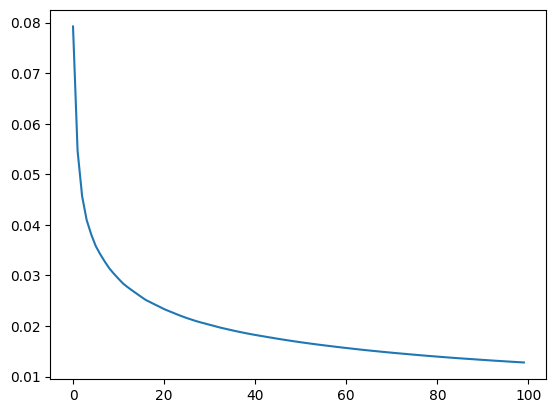

In [ ]:
# X axis is number of components.
plt.plot(np.mean(mse, axis=0))

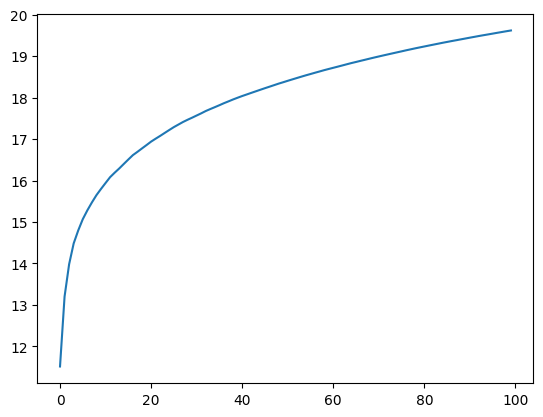

In [22]:
plt.plot(np.mean(psnr, axis=0))

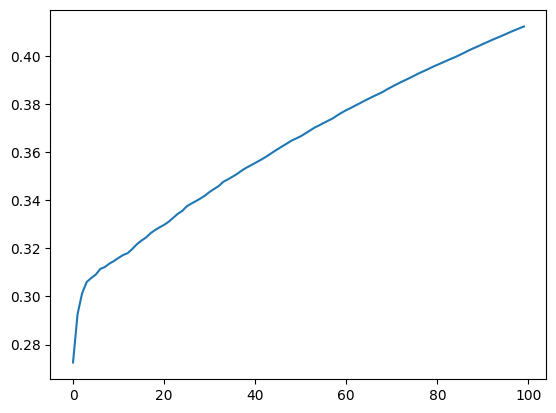

In [23]:
plt.plot(np.mean(ssim, axis=0))